In [0]:
import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.naive_bayes import GaussianNB

In [2]:
from google.colab import files
#Upload Cross-sectional MRI Data (for Young, Middle Aged, Nondemented and Demented Older Adults)
uploaded1 = files.upload()

Saving oasis_cross-sectional.csv to oasis_cross-sectional (1).csv


In [3]:
# Upload Longitudinal MRI Data (in Nondemented and Demented Older Adults)
uploaded2 = files.upload()

Saving oasis_longitudinal.csv to oasis_longitudinal (1).csv


**Cross-sectional MRI Data:** This set consists of a cross-sectional collection of 436 subjects aged 18 to 96. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 100 of the included subjects over the age of 60 have been clinically diagnosed with very mild to moderate Alzheimer’s disease (AD). 


**Longitudinal MRI Data:** This set consists of a longitudinal collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 

In [0]:
long_df = pd.read_csv("oasis_longitudinal.csv")
cross_df = pd.read_csv("oasis_cross-sectional.csv")

In [5]:
cross_df.columns

Index(['ID', 'M/F', 'Hand', 'Age', 'Educ', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF', 'Delay'],
      dtype='object')

### What do variables stand for
* ID - Subject ID
* Delay - MR Delay b/w previous examinations
* Group (Converted / Demented / Nondemented)
* Visit - Number of visit
* MR.Delay - Time between two examinations
#### Demographics Info
* M/F - Gender
* Hand - Handedness (actually all subjects were right-handed so I will drop this column)
* Age
* EDUC - Years of education
* SES - Socioeconomic status as assessed by the Hollingshead Index of Social Position and classified into categories from 1 (highest status) to 5 (lowest status)
#### Clinical Info
* MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best)

* CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild dementia, 1 = mild dementia, 2 = moderate dementia)
#### Derived anatomic volumes
* eTIV - Estimated total intracranial volume, mm3
* nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
* ASF - Atlas scaling factor (unitless). Computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

Making a binary feature called demented, showing whether the person has any form of dementia. Every person in the Cross-sectional who has a CDR above 0, and everyone in the Longitudinal who belongs to groups Demented and Converted, will get demented = 1.

In [0]:
from math import isnan

# Preserving the NaNs so they can be imputed later.
def binarize_cdr(x):
    if isnan(x):
        return x
    else:
        return 1 if x > 0 else 0

# There are no NaNs in the Group column.
def binarize_group(x):
    return 1 if x != 'Nondemented' else 0

long_df['demented'] = long_df['Group'].apply(binarize_group)
cross_df['demented'] = cross_df['CDR'].apply(binarize_cdr)

Combining the Cross-sectional and the Longitudinal.

In [0]:
def combine_dfs(long, cross):
    
    # Renaming the education column to match between the two dataframes.
    long = long.rename(columns={'EDUC': 'Educ'})

    # Combining the rows of each person in the Longitudinal into a single one, taking the mean of each feature's values.
    mean_long = long.groupby('Subject ID').mean()

    # Adding the columns of strings back, as they were dropped by the mean() 
    mean_long = pd.merge(mean_long, long[['Subject ID', 'M/F', 'Group']].drop_duplicates(), on='Subject ID', how='right').reset_index(drop=True)

    # Then concatenating the new condensed dataframe with the Cross-sectional.
    total = pd.concat((cross, mean_long)).reset_index(drop=True)
    return total, mean_long

total_train, long_train = combine_dfs(long_df, cross_df)

Dropping the redundant columns




In [0]:
total_train = total_train.drop(['Visit', 'Hand', 'MR Delay', 'Delay', 'Subject ID', 'ID'], axis=1)


In [9]:
total_train.head()

,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,demented,Group
0,F,74.0,2.0,3.0,29.0,0.0,1344.0,0.743,1.306,0.0,NaN
1,F,55.0,4.0,1.0,29.0,0.0,1147.0,0.810,1.531,0.0,NaN
2,F,73.0,4.0,3.0,27.0,0.5,1454.0,0.708,1.207,1.0,NaN
3,M,28.0,NaN,NaN,NaN,NaN,1588.0,0.803,1.105,NaN,NaN
4,M,18.0,NaN,NaN,NaN,NaN,1737.0,0.848,1.010,NaN,NaN


## Feature selection

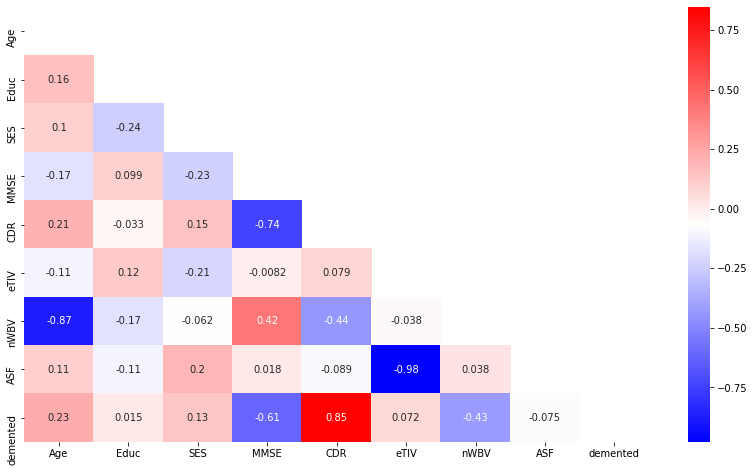

In [10]:
# Plot a correlation heatmap with all the dataset's features.
plt.figure(figsize=(14, 8))
corr = total_train.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, cmap='bwr')

In [11]:
#printing all the correlations to Demented in descending order
corr['demented'].sort_values(ascending=False)

demented    1.000000
CDR         0.847303
Age         0.227699
SES         0.134962
eTIV        0.071639
Educ        0.014759
ASF        -0.074983
nWBV       -0.427433
MMSE       -0.610350
Name: demented, dtype: float64

It is time to choose the features to use in the model.

Looking at the demented row and column, it has a great or decent correlation with everything except ASF and eTIV, so they will be dropped.
Since CDR was used to engineer the demented feature, it will be dropped.
The correlation of nWBV with age is so significant that one of them should perhaps be dropped. Which one? I will go for the latter in order to keep the model more practical. After all, it is far easier to find out a person's age than to conduct a brain scan. The model could therefore be used digitally before any hospital visit to find out the need to for such a visit. 


In [0]:
features_to_drop = ['Group', 'CDR', 'ASF', 'eTIV', 'nWBV']
total_train = total_train.drop(features_to_drop, axis=1) 

Encoding the M/F column. In other words, mapping the M and F strings into 0 and 1 respectively so that it could be used by ML models.

In [0]:
total_train['M/F'] = pd.get_dummies(total_train['M/F'])

## Missing data

In [14]:
total_train.isna().sum()

M/F           0
Age           0
Educ        201
SES         228
MMSE        201
demented    201
dtype: int64

In [0]:
h_train = total_train[~np.isnan(total_train['demented'])]

In [16]:
h_train.isna().sum()

M/F          0
Age          0
Educ         0
SES         27
MMSE         0
demented     0
dtype: int64

In [0]:
# filling out NaNs with most frequent values
h_train["SES"].fillna(h_train["SES"].median(), inplace=True)

In [18]:
h_train.shape

(385, 6)

## Spliting the data

In [0]:
def split(df, test_size=0.2):
    split_index = int(len(df)*test_size)
    return df[:-split_index], df[-split_index:]

Splitting the data into 80%, 70% and 60% training sets

In [0]:
train_80, val_80 = split(h_train, test_size = 0.2)
train_70, val_70 = split(h_train, test_size = 0.3)
train_60, val_60 = split(h_train, test_size = 0.4)
train = [train_80, train_70, train_60]
test = [val_80, val_70, val_60]

## Modeling

In [21]:
scores = []
classifiers = [GaussianNB(), DecisionTreeClassifier(), SVC()]

cv = KFold(n_splits=10, random_state=42, shuffle=False)
scaler = MinMaxScaler(feature_range=(0, 1))

for clf in classifiers:
  print(clf , " results \n")
  for t in range(3):
    y = train[t].iloc[:,-1]
    X = train[t].drop('demented', axis=1)
      
    X = scaler.fit_transform(X)
    
    for train_index, test_index in cv.split(X):
    
      X_train, X_test, y_train, y_test = X[train_index], X[test_index], y.iloc[train_index], y.iloc[test_index]
      clf.fit(X_train, y_train)
      scores.append(clf.score(X_test, y_test))

    y_predicted = clf.predict(scaler.fit_transform(test[t].drop('demented', axis=1)))  
    print(classification_report(test[t].demented,y_predicted))
    print("Classifier score", np.mean(scores), "\n")
    scores = []

GaussianNB(priors=None, var_smoothing=1e-09)  results 

              precision    recall  f1-score   support

         0.0       0.64      0.97      0.77        36
         1.0       0.95      0.51      0.67        41

    accuracy                           0.73        77
   macro avg       0.80      0.74      0.72        77
weighted avg       0.81      0.73      0.71        77

Classifier score 0.8213978494623657 

              precision    recall  f1-score   support

         0.0       0.64      1.00      0.78        57
         1.0       1.00      0.45      0.62        58

    accuracy                           0.72       115
   macro avg       0.82      0.72      0.70       115
weighted avg       0.82      0.72      0.70       115

Classifier score 0.8185185185185185 

              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79        75
         1.0       1.00      0.49      0.66        79

    accuracy                           0.74       

**Conclusion:** Naive Bayes scored highest on 80-20 split. Decision Tree performed well on 60-40 split, while SVM on 80-20. Overall Naive Bayes excelled all other classifiers.